In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import healpy as hp
import intake
from easygems import healpix as egh

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean
import seaborn as sns
from matplotlib import colormaps
cmap = colormaps["Set2"]
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap


import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # don't warn us about future package conflicts
import time

# using functions defined in healpix_utils.py 
# files has to be in the same dir
from healpix_utils import * 


# Reading Data

In [2]:
cat_hk25 = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")['EU']

def select(ds):
    return ds.sel(time=slice('2020-03-01', '2021-03-01')).mean('time')

def regrid(ds, idx = None):
    if idx == None:
        deg = 1. # degree for regridded cell
        idx = get_nn_lon_lat_index(
            2**zoom, np.linspace(0+deg/2, 360-deg/2, int(360/deg)), 
            np.linspace(-90+deg/2, 90-deg/2, int(180/deg))
        )
    return ds.drop_vars(["lat", "lon"], errors='ignore').isel(cell=idx)
    
def convert(ds):
    if 'value' in ds.dims:
        return ds.rename_dims({'value': 'cell'})
    if 'pressure' in ds.dims:
        return ds.rename_dims({'pressure': 'level'})
    else:
        return ds
        
def log(ds, mid):
    print(mid)
    print('\n')
    print(ds)
    print('-'*10)
    return ds



In [3]:
zoom = 7
model_ids = ["ERA5",
             "MERRA2",
             "icon_ngc4008", 
             "icon_d3hp003", 
             'ifs_tco3999-ng5_rcbmf_cf',
             'um_glm_n1280_CoMA9_TBv1p2',
             'um_glm_n1280_GAL9',
             'um_glm_n2560_RAL3p3',
             'nicam_gl11',
            ]
models= {mid: cat_hk25[mid](zoom=zoom, chunks="auto").to_dask()
                                                             .pipe(select)
                                                             .pipe(convert)
                                                             # .pipe(regrid)
                                                             .pipe(log, mid = mid)
                                                                for mid in model_ids}

# model specific conversions
mids = ['ERA5']

for mid in mids:
    models[mid] = models[mid].assign(rsdt=lambda ds: ds['tisr'] / (3600*24)) # converting to W/m2
    models[mid] = models[mid].assign(rsut=lambda ds: (ds['tisr'] - ds['tsr']) / (3600*24)) # calculating downward sw flux
    models[mid] = models[mid].assign(ta=lambda ds: ds['t']) # renaming temperature

mids = ['MERRA2']

for mid in mids:
    models[mid] = models[mid].assign(rsdt=lambda ds: ds['swtdn']) # converting to W/m2
    models[mid] = models[mid].assign(rsut=lambda ds: (ds['swtdn'] - ds['swtnt'])) # calculating downward sw flux
    models[mid] = models[mid].assign(ta=lambda ds: ds['t']) # renaming temperature

# mids = [  'ifs_tco2559_rcbmf',
#          'ifs_tco3999-ng5_deepoff',
#          'ifs_tco3999_rcbmf']

# for mid in mids:
#     models[mid] = models[mid].assign(rsdt=lambda ds: ds['tisr'] / (3600)) # converting to W/m2
#     models[mid] = models[mid].assign(rsut=lambda ds: (ds['tisr'] - ds['tsr']) / (3600)) # calculating downward sw flux

ERA5


<xarray.Dataset> Size: 543MB
Dimensions:  (cell: 196608, level: 37)
Coordinates:
  * cell     (cell) float32 786kB 0.0 1.0 2.0 ... 1.966e+05 1.966e+05 1.966e+05
    crs      float32 4B ...
    lat      (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
  * level    (level) float32 148B 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1e+03
    lon      (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
Data variables: (12/111)
    100u     (cell) float32 786kB dask.array<chunksize=(147456,), meta=np.ndarray>
    100v     (cell) float32 786kB dask.array<chunksize=(147456,), meta=np.ndarray>
    10fg     (cell) float32 786kB dask.array<chunksize=(147456,), meta=np.ndarray>
    10si     (cell) float32 786kB dask.array<chunksize=(147456,), meta=np.ndarray>
    10u      (cell) float32 786kB dask.array<chunksize=(147456,), meta=np.ndarray>
    10v      (cell) float32 786kB dask.array<chunksize=(147456,), meta=np.ndarray>
    ...       ...
    uvb      (cell)

# Albedo

In [4]:
# calculating albedo
for key, data in models.items(): 
    print(key)
    data.pipe(calc_albedo, tag = 't')


ERA5
MERRA2
icon_ngc4008
icon_d3hp003
ifs_tco3999-ng5_rcbmf_cf
um_glm_n1280_CoMA9_TBv1p2
um_glm_n1280_GAL9
um_glm_n2560_RAL3p3
nicam_gl11


In [5]:
#ceres data

ddir_ceres = '/pool/data/ICDC/atmosphere/ceres_ebaf/DATA/' # on Levante
ceres = xr.open_dataset(ddir_ceres + "CERES_EBAF_Ed4.2_v03_200003-202312.nc")
ceres = ceres[[
    "toa_sw_all_mon", "toa_lw_all_mon", "solar_mon"]
        ].pipe(select).rename({"toa_sw_all_mon":"rsut", "toa_lw_all_mon": "rlut", "solar_mon": "rsdt"})

ceres.pipe(calc_albedo, tag = 't')
ceres.pipe(calc_lat_profile, var = ['rsut', 'albedot'])
obs = {'ceres_global':ceres}

In [6]:
# regrid data to lat lon and calculate zonal means

model_ids = ["ERA5",
             "MERRA2",
             "icon_ngc4008", 
             "icon_d3hp003", 
             'ifs_tco3999-ng5_rcbmf_cf',
             'um_glm_n1280_CoMA9_TBv1p2',
             'um_glm_n1280_GAL9',
             'um_glm_n2560_RAL3p3',
             'nicam_gl11',
            ]
models_regrid = {mid: models[mid].pipe(regrid)
                                 .pipe(calc_lat_profile, var = ['rsut', 'albedot'])
                                 # .pipe(log, mid)
                                for mid in model_ids}

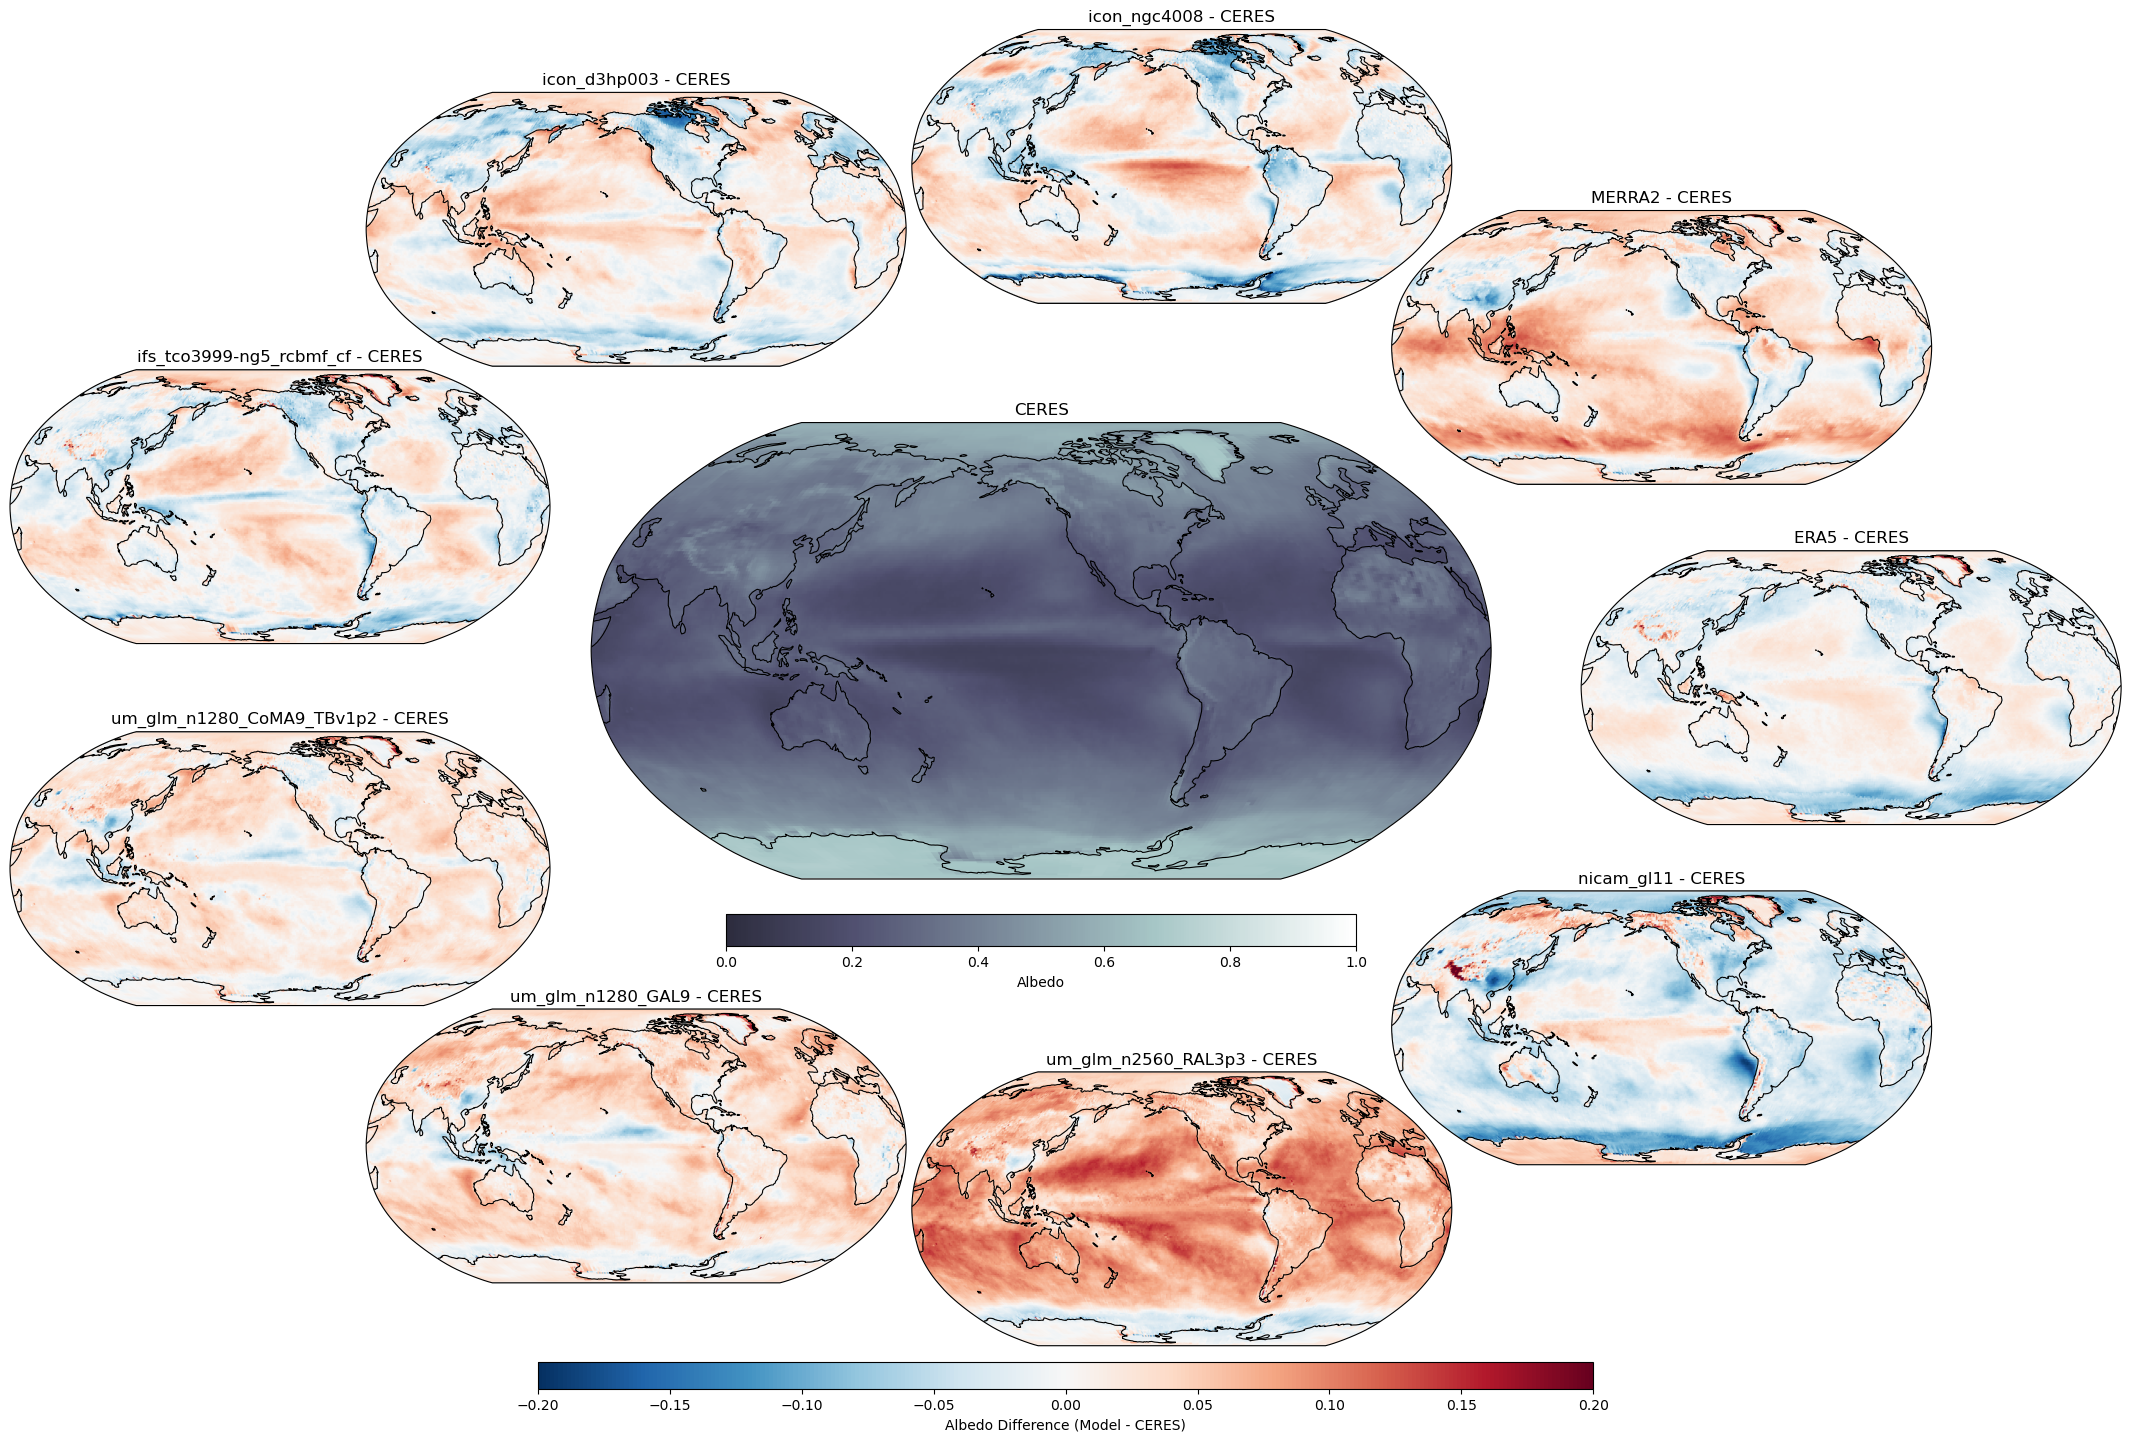

In [7]:
# plotting the albedos in a circular arrangement

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """Crop a colormap between minval and maxval (0–1 range)."""
    new_cmap = LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap
cropped_bone = truncate_colormap(mpl.colormaps['bone'], 0.2, 1.0)

projection = ccrs.Robinson(central_longitude=-135.5808361)

n_models = len(models)
theta = np.linspace(0, 2 * np.pi, n_models, endpoint=False)

fig = plt.figure(figsize=(18, 14))

# Plot CERES albedo in the center
center_ax = fig.add_axes([0.25, 0.25, 0.5, 0.5], projection=projection)
center_ax.set_global()
imsh_cent = center_ax.imshow(
    obs['ceres_global']['albedot'],
    transform=ccrs.PlateCarree(),
    extent=[0, 360, -90, 90],
    origin='lower',
    cmap= cropped_bone,
    vmin=0.0, vmax=1.,
    # norm=shifted_norm,
)

center_ax.add_feature(cf.COASTLINE, linewidth=0.8)
center_ax.set_title("CERES")

# Coordinates for placing surrounding axes
r = 1.5  # radius from center; this can be adjusted to accomodate a different number of models
center = [0.5, 0.42]  # normalized figure coordinates; 0,42 in vertical axis to adjust for the bottom colorbar
size_p = 0.3

var = 'albedot'
axes = []
for i, (key, angle) in enumerate(zip(models.keys(), theta)):
    dx = r * size_p * np.cos(angle)
    dy = r * size_p * np.sin(angle)
    ax_pos = [center[0] + dx - size_p/2, center[1] + dy - size_p/2, size_p, size_p]  # [left, bottom, width, height]

    ax = fig.add_axes(ax_pos, projection=projection)
    ax.set_global()
    # if i ==0:
    models_regrid[key][var + '_ceres_dif'] = models_regrid[key][var] - obs['ceres_global'][var]
    imsh = ax.imshow(
        models_regrid[key][var + '_ceres_dif'],
        transform=ccrs.PlateCarree(),
        extent=[0, 360, -90, 90],
        origin='lower',
        cmap='RdBu_r',
        vmin=-0.2, vmax=0.2
    )
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.set_title(f"{key} - CERES")
    axes.append(ax)

cbar = fig.colorbar(
    imsh,
    ax=axes,
    orientation='horizontal',
    location='bottom',
    pad=0.01,
    shrink=0.5,
    aspect=40, 
    label='Albedo Difference (Model - CERES)'
)

cbar_center = fig.colorbar(
    imsh_cent,
    ax=center_ax,
    orientation='horizontal',
    location='bottom',
    pad=0.05,
    shrink=0.7,
    label='Albedo'
)
plt.savefig('albedo_circular.png', dpi=256, bbox_inches='tight')
plt.show()


ERA5 0.193162202835083
MERRA2 0.15230917930603027
icon_ngc4008 0.3707571029663086
icon_d3hp003 0.5121965408325195
ifs_tco3999-ng5_rcbmf_cf 14.743278741836548
um_glm_n1280_CoMA9_TBv1p2 14.8581383228302
um_glm_n1280_GAL9 14.446893453598022
um_glm_n2560_RAL3p3 14.376130819320679
nicam_gl11 22.90365219116211


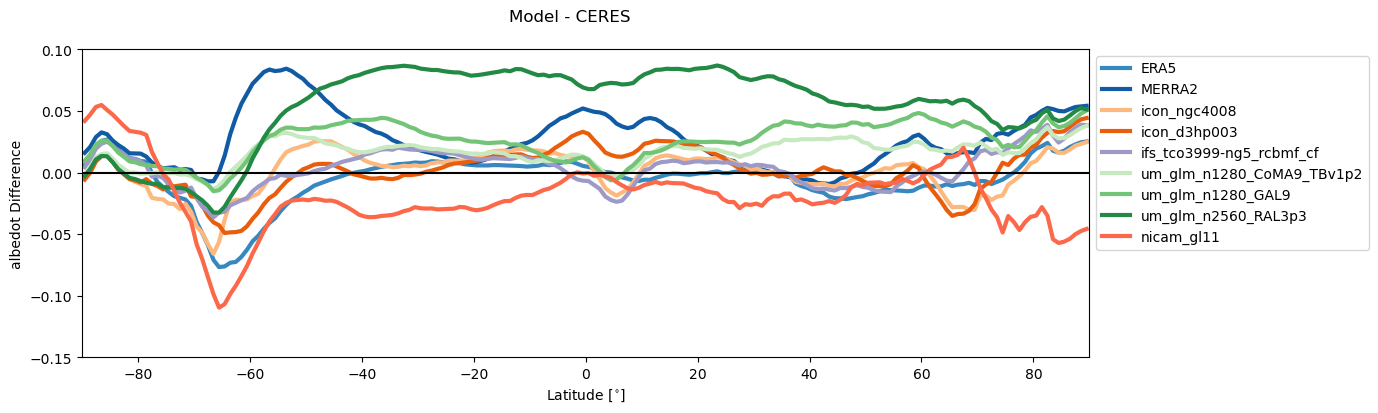

In [8]:
# plotting zonal means

plot_vars = ['albedot']

f,axes = plt.subplots(1,1, figsize=(13,4))

era5_colors = sns.color_palette("Blues", n_colors=5)[3:]
icon_colors = sns.color_palette("Oranges", n_colors=2)
ifs_colors = sns.color_palette("Purples", n_colors=1)
um_colors = sns.color_palette("Greens", n_colors=3)
nicam_colors = sns.color_palette("Reds", n_colors=1)

colors = era5_colors + icon_colors  + ifs_colors + um_colors + nicam_colors

i = 0

for key, data in models_regrid.items():
        time1 = time.time()
        for v_id,v in enumerate(plot_vars): 
            dif  =  data[v + '_lat_prof'] - obs['ceres_global'][v + '_lat_prof']
            dif.plot(ax=axes , lw=3, c=colors[i], label=key)
        i+=1
        print(key, time.time() - time1)

ax = axes
ax.set_ylabel(v + " Difference")
ax.set_title('')
ax.set_xlabel(r"Latitude [$^{\circ}$]")
ax.axhline(color = 'k')

axes.set_ylim(-.15, .1)
axes.set_xlim(-90, 90)
lgnd = axes.legend(bbox_to_anchor=(1, 1))
f.suptitle("Model - CERES");

plt.savefig('albedo_dif_lat_prof.png', bbox_extra_artists = (lgnd,), bbox_inches = 'tight',  dpi = 256)

# LTS

In [9]:
model_ids = ["ERA5",
             'ifs_tco3999-ng5_rcbmf_cf',]
for mid in model_ids:
    models_regrid[mid].pipe(calc_lts, temp_var='ta', p_lev_dim='level', p_unit='hPa')


model_ids = [# "icon_ngc4008", # have to be interpolated to pressure coordinates; too lazy 
             "icon_d3hp003", ]
for mid in model_ids:
    models_regrid[mid].pipe(calc_lts, temp_var='ta', p_lev_dim='pressure', p_unit='Pa')


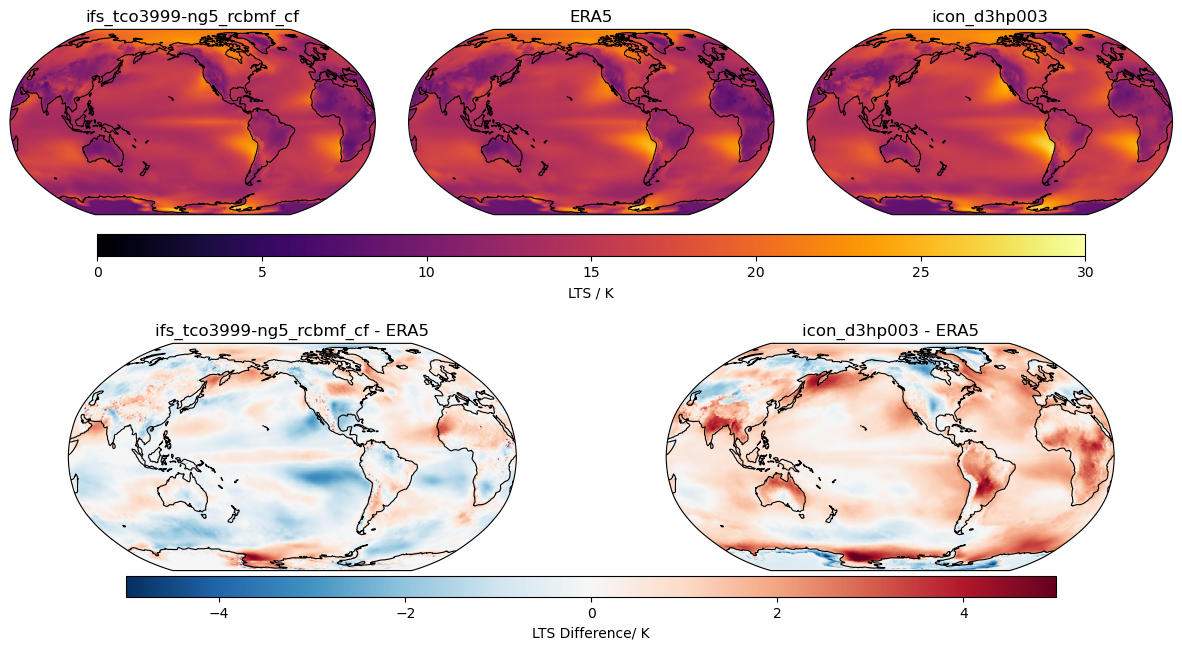

In [10]:
# plotting LTS

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.gridspec as gridspec

projection = ccrs.Robinson(central_longitude=-135.5808361)

fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(2, 6, figure=fig, height_ratios=[1, 1], hspace=0.25)

# --- Top row: 3 evenly spaced plots
ax_top = [
    fig.add_subplot(gs[0, 0:2], projection=projection),  # IFS
    fig.add_subplot(gs[0, 2:4], projection=projection),  # ERA5
    fig.add_subplot(gs[0, 4:6], projection=projection),  # ICON
]

# Bottom row: 2 plots, each spans 3 columns
ax_bottom = [fig.add_subplot(gs[1, 0:3], projection=projection),   
            fig.add_subplot(gs[1, 3:6], projection=projection)]

var = 'lts'
model_ids = ['ifs_tco3999-ng5_rcbmf_cf', 'ERA5', 'icon_d3hp003']

# Top row: absolute LTS
for i, key in enumerate(model_ids):
    # if i ==1:
    ax_top[i].set_global()
    im_abs = ax_top[i].imshow(
        models_regrid[key][var],
        transform=ccrs.PlateCarree(),
        extent=[0, 360, -90, 90],
        origin="lower",
        cmap="inferno",
        vmin=0, vmax=30
    )
    ax_top[i].add_feature(cf.COASTLINE, linewidth=0.8)
    ax_top[i].set_title(f"{key}")

# Bottom row: differences
diff_keys = ['ifs_tco3999-ng5_rcbmf_cf', 'icon_d3hp003']

for i, key in enumerate(diff_keys):
    # if i ==1:
    diff = models_regrid[key][var] - models_regrid['ERA5'][var]
    models_regrid[key][var + '_dif'] = diff
    ax_bottom[i].set_global()
    im_diff = ax_bottom[i].imshow(
        diff,
        transform=ccrs.PlateCarree(),
        extent=[0, 360, -90, 90],
        origin="lower",
        cmap="RdBu_r",
        vmin=-5, vmax=5
    )
    ax_bottom[i].add_feature(cf.COASTLINE, linewidth=0.8)
    ax_bottom[i].set_title(f"{key} - ERA5")

# Colorbars
cbar_abs = fig.colorbar(
    im_abs,
    ax=ax_top,
    orientation='horizontal',
    pad=0.07,
    shrink=0.85,
    aspect = 45,
    label='LTS / K'
)

cbar_diff = fig.colorbar(
    im_diff,
    ax=ax_bottom,
    orientation='horizontal',
    pad=0.02,
    shrink=0.8,
    aspect = 45,
    label='LTS Difference/ K'
)

plt.savefig('lts_differences.png', dpi=256, bbox_inches='tight')
plt.show()


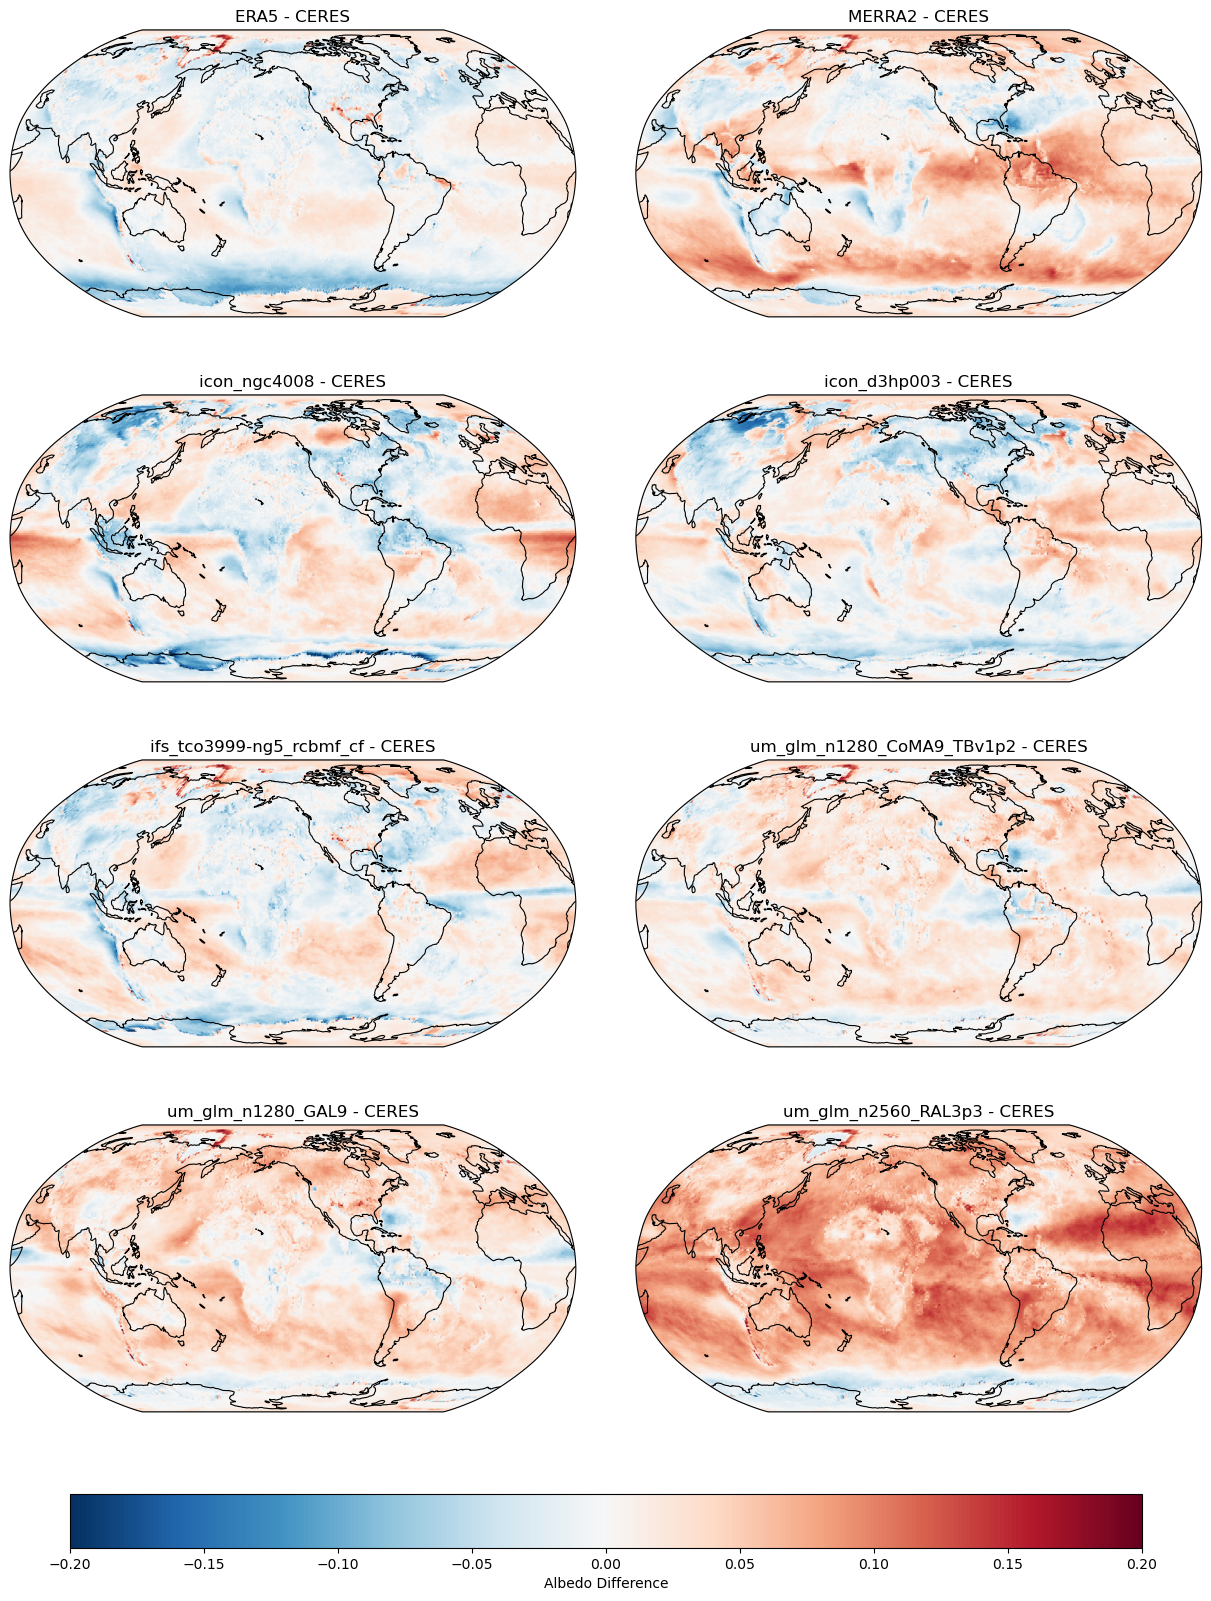

In [11]:
# simple plot arrangemnet example
projection = ccrs.Robinson(central_longitude=-135.5808361)
fig, axs = plt.subplots(
    4, 2, figsize=(6 * 2, 4 * 4),
    subplot_kw={"projection": projection},
    gridspec_kw={'wspace': 0.1, 'hspace': 0.1},  # Adjust spacing
    constrained_layout=True
)

axs = axs.flatten()
var = 'albedot'
for i, key in enumerate(list(models.keys())[:8]):
    models_regrid[key][var + '_ceres_dif'] = models_regrid[key][var] - obs['ceres_global'][var]

    axs[i].set_global()  
    imsh = axs[i].imshow(
        models_regrid[key][var + '_ceres_dif'],
        transform=ccrs.PlateCarree(), 
        origin="lower",
        cmap="RdBu_r",
        vmin=-0.2, vmax=0.2
    )
    axs[i].add_feature(cf.COASTLINE, linewidth=0.8)
    axs[i].set_title(f"{key} - CERES")

# Add a single horizontal colorbar that spans all subplots
cbar = fig.colorbar(
    imsh,
    ax=axs,
    orientation='horizontal',
    location='bottom',
    pad=0.05,
    shrink=0.9,
    label='Albedo Difference'
)

plt.savefig('albedo_dif.png', dpi=512)
plt.show()
